In [1]:
import sys
import os

import matplotlib.pyplot as plt
import pandas as pd
import polars as pl
import numpy as np
import seaborn as sns
import json
from jupyterthemes import jtplot
from tqdm.auto import tqdm
jtplot.style()
%matplotlib inline

C:\Users\chris\.virtualenvs\INF2008-XgWG3lwF\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pl.read_csv("polars/filtered_data.csv")

In [6]:
data.head()

cluster_1_span,cluster_1_mean,cluster_1_grad,cluster_1_std,cluster_2_span,cluster_2_mean,cluster_2_grad,cluster_2_std,cluster_3_span,cluster_3_mean,cluster_3_grad,cluster_3_std,cluster_4_span,cluster_4_mean,cluster_4_grad,cluster_4_std,file,label
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64
1.239184,17.334821,-0.097751,7.718903,0.942478,16.8,0.223039,6.934051,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1054130,1
1.797689,27.150838,15.341443,184.025655,1.797689,27.150838,15.341443,184.025655,1.134464,37.275,0.336264,18.102501,0.0,0.0,0.0,0.0,1167250,1
0.663225,16.977778,-1.883207,12.997187,3.473205,16.369048,0.277388,6.213289,0.10472,17.227273,-10.728342,69.234828,3.473205,16.369048,0.277388,6.213289,1494273,1
2.879793,18.853448,0.554875,8.454402,1.780236,16.809322,0.066214,7.934806,0.0,16.25,0.0,8.125,0.0,0.0,0.0,0.0,1603077,1
3.438299,18.205128,1.769237,14.799642,0.05236,18.575,-20.631737,150.356195,0.034907,18.6875,22.137006,163.381049,3.438299,18.205128,1.769237,14.799642,1609861,1


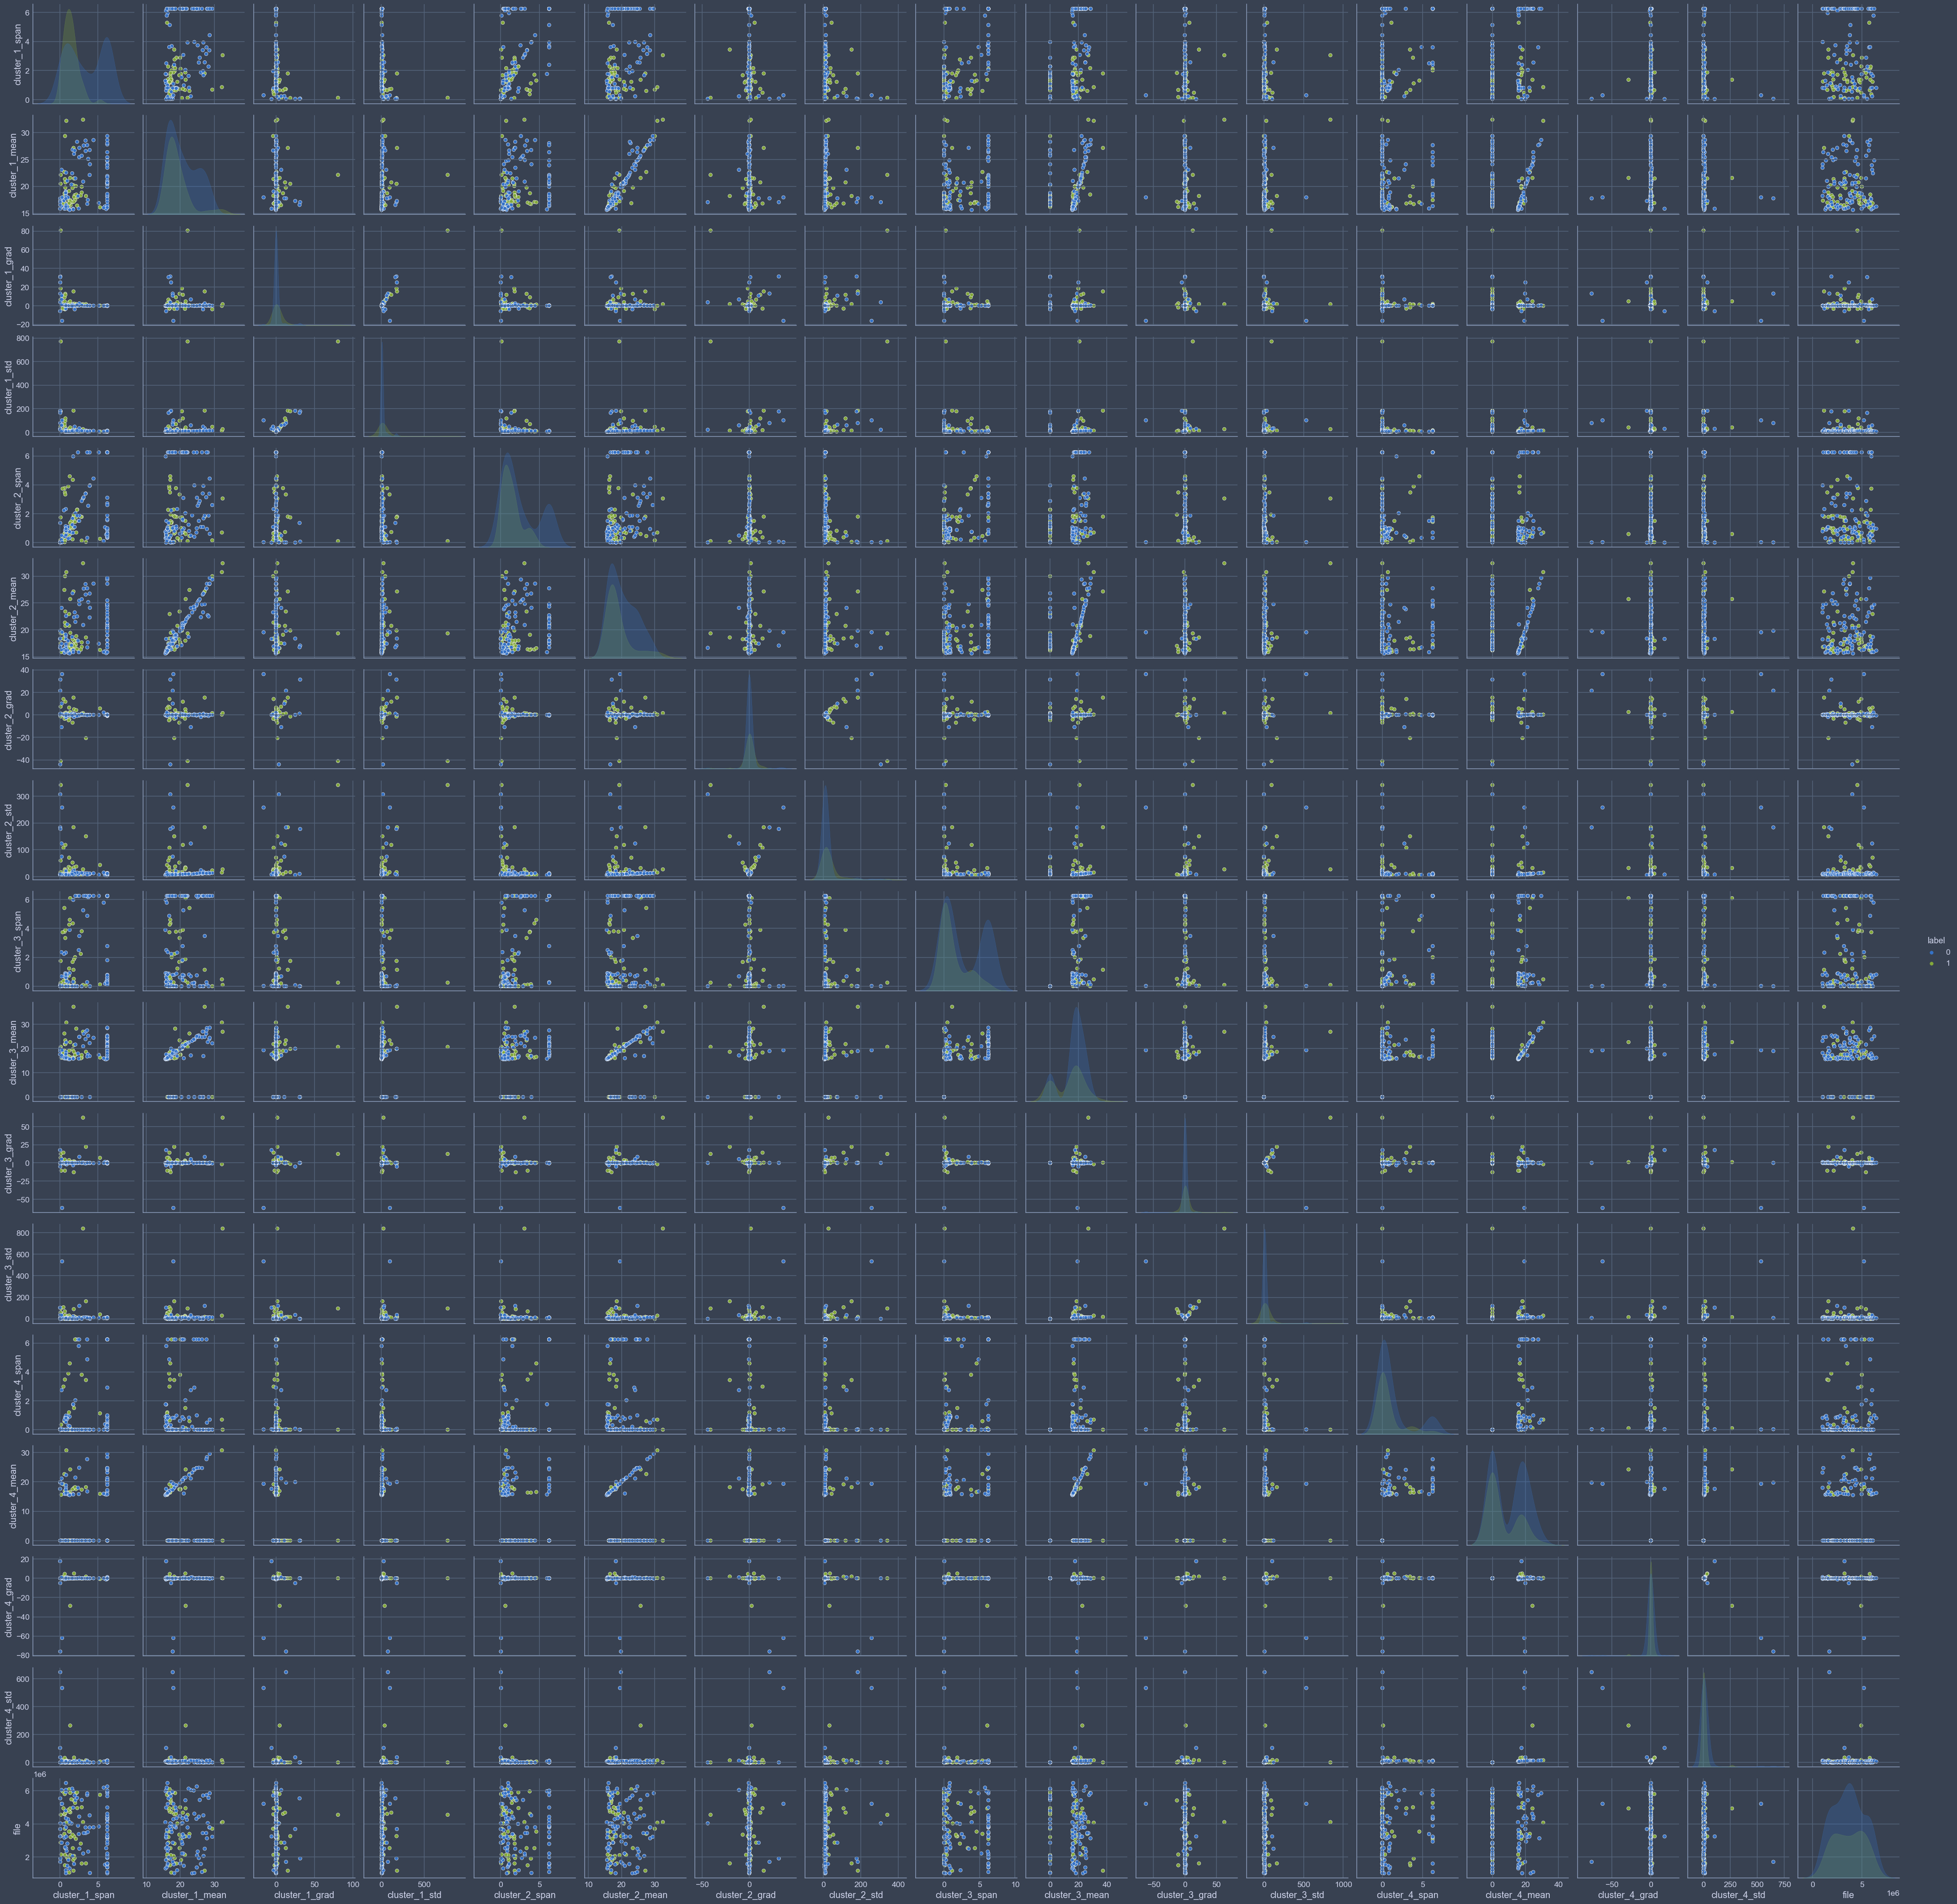

In [19]:
sns.pairplot(data.to_pandas(), hue="label")

# Model Preparation

In [4]:
import sklearn
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, ComplementNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from joblib import parallel_backend

In [8]:
X = data.drop(["label", "file"])
Y = data["label"]

In [9]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=True, stratify=Y)

## Support Vector Classifier

In [5]:
svc = make_pipeline(StandardScaler(), SVC(gamma='auto'))

In [12]:
with parallel_backend("threading", n_jobs=12):
    svc.fit(x_train.to_numpy(), y_train)

## Random Forest

In [24]:
rfc = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42, n_jobs=12)
with parallel_backend("threading", n_jobs=12):
    rfc.fit(x_train.to_numpy(), y_train)

## AdaBoost

In [27]:
abc = AdaBoostClassifier(n_estimators=100, random_state=42)
with parallel_backend("threading", n_jobs=12):
    abc.fit(x_train.to_numpy(), y_train)

# Validation

In [13]:
import pp_cnf_matrix as ppcm
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.inspection import DecisionBoundaryDisplay

## SVC

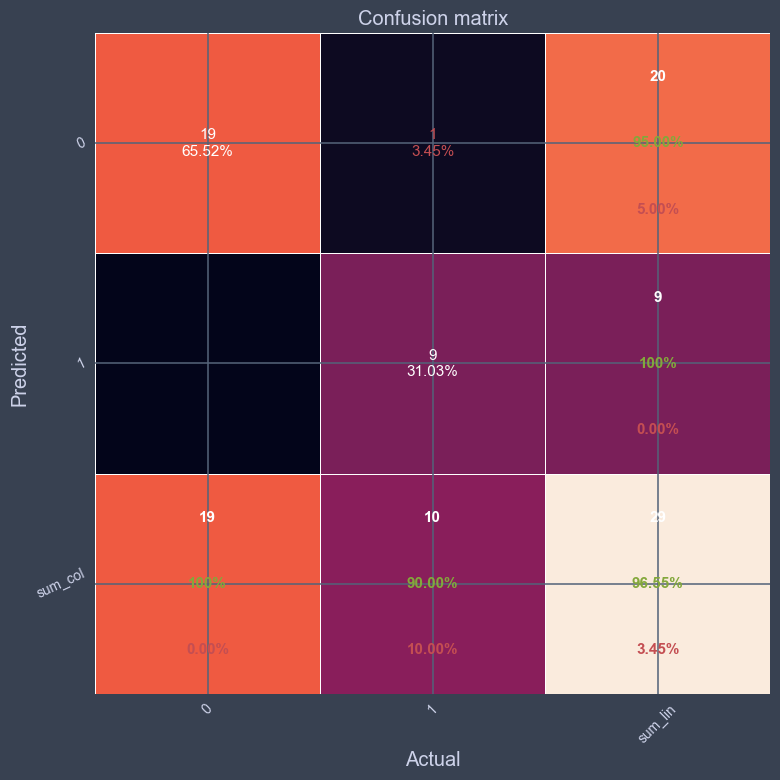

In [15]:
svc_pred = svc.predict(x_test.to_numpy())
cnf_matrix = confusion_matrix(y_test, svc_pred)
cnf_matrix = pd.DataFrame(cnf_matrix)
ppcm.pretty_plot_confusion_matrix(cnf_matrix, cmap=sns.color_palette("rocket", as_cmap=True))

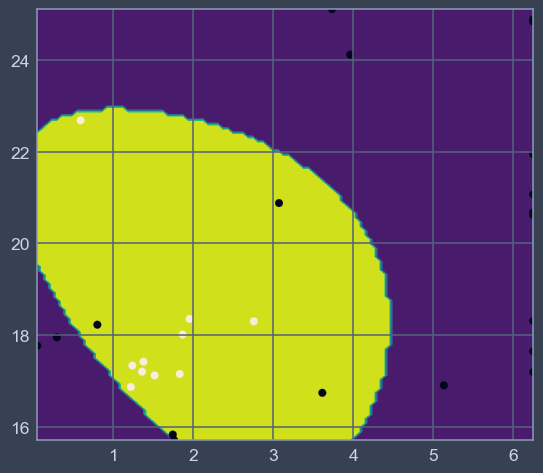

In [23]:
feature_1, feature_2 = np.meshgrid(
    np.linspace(x_test["cluster_1_span"].min(), x_test["cluster_1_span"].max(), 100),
    np.linspace(x_test["cluster_1_mean"].min(), x_test["cluster_1_mean"].max(), 100)
)
grid = np.vstack([feature_1.ravel(), feature_2.ravel()]).T
svc2 = make_pipeline(StandardScaler(), SVC(gamma='auto')).fit(x_train[["cluster_1_span", "cluster_1_mean"]].to_numpy(), y_train)
y_pred = np.reshape(svc2.predict(grid), feature_1.shape)
display = DecisionBoundaryDisplay(
    xx0=feature_1, xx1=feature_2, response=y_pred
)
display.plot()
display.ax_.scatter(x_test["cluster_1_span"], x_test["cluster_1_mean"], c=y_test, cmap=sns.color_palette("rocket", as_cmap=True))
plt.show()

## RFC

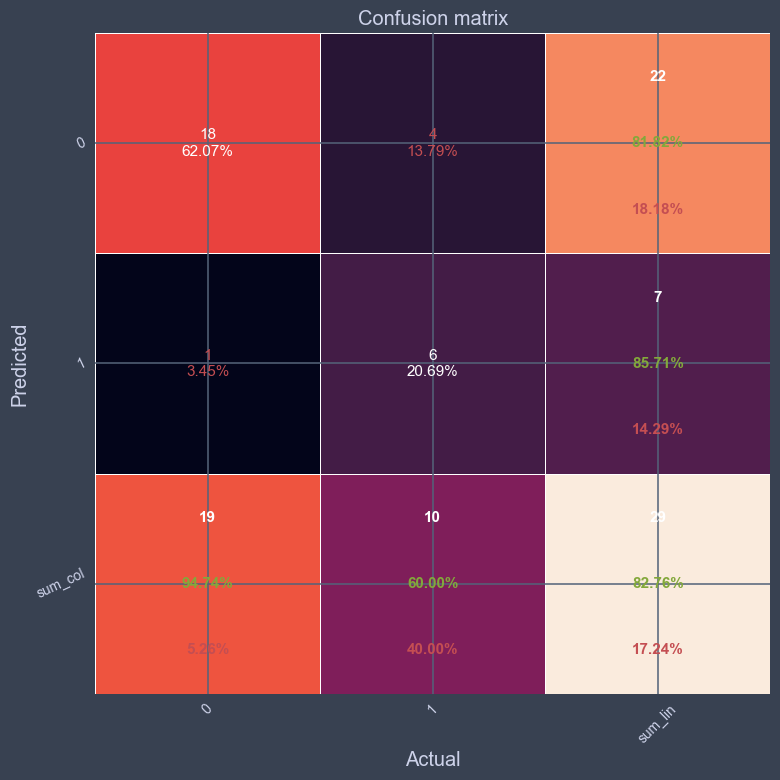

In [26]:
rfc_pred = rfc.predict(x_test.to_numpy())
cnf_matrix = confusion_matrix(y_test, rfc_pred)
cnf_matrix = pd.DataFrame(cnf_matrix)
ppcm.pretty_plot_confusion_matrix(cnf_matrix, cmap=sns.color_palette("rocket", as_cmap=True))

## ABC

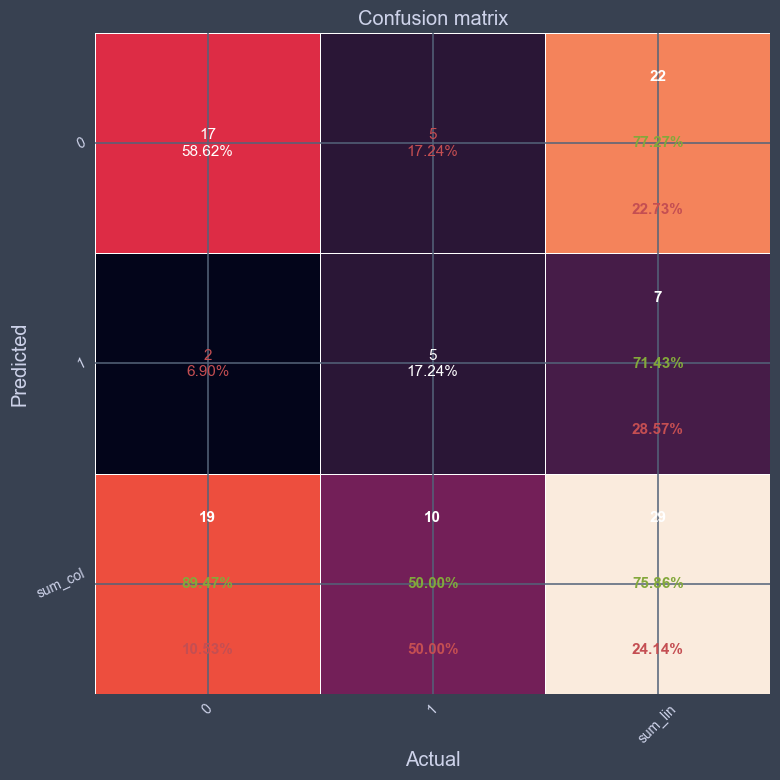

In [28]:
abc_pred = abc.predict(x_test.to_numpy())
cnf_matrix = confusion_matrix(y_test, abc_pred)
cnf_matrix = pd.DataFrame(cnf_matrix)
ppcm.pretty_plot_confusion_matrix(cnf_matrix, cmap=sns.color_palette("rocket", as_cmap=True))

# 10-Fold Cross Validation

In [38]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, auc, precision_recall_curve
from sklearn.metrics import roc_curve as sk_roc_curve

In [30]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
skf.get_n_splits(X, Y)

10

In [61]:
def ten_fold_cross_validation(skf, model, X, Y):
    outputs = []
    for i, (train_index, test_index) in enumerate(skf.split(X, Y)):
        print("---", f"Fold {i}", "---")
        model.fit(X[train_index].to_numpy(), Y[train_index])
        preds = model.predict(X[test_index].to_numpy())
        print(model.score(X[test_index].to_numpy(), Y[test_index]))
        proba = model.predict_proba(X[test_index].to_numpy())[:,1]
        outputs.append({
            "preds": preds,
            "y": Y[test_index],
            "proba": proba,
            "test_indices": test_index
        })
    return outputs

In [71]:
def k_fold_roc_curve(model_outputs, model_name:str):
    fig, ax = plt.subplots(2, 1, figsize=(8.27, 11.69), dpi=100)
    tprs, aurocs = [], []
    tpr_threshes = []
    fpr_mean = np.linspace(0, 1, 1000)
    precisions, auprcs = [], []
    recall_threshes = []
    recall_mean = np.linspace(0, 1, 1000)
    for fold_idx, fold in enumerate(tqdm(model_outputs)):
        # ROC
        fpr, tpr, tpr_thresh = sk_roc_curve(fold['y'], fold['proba'])
        tpr_threshes.append(tpr_thresh[np.abs(tpr-0.85).argmin()])
        tpr_interp = np.interp(fpr_mean, fpr, tpr)
        tpr_interp[0] = 0.0
        tprs.append(tpr_interp)
        aurocs.append(auc(fpr, tpr))
        ax[0].plot(fpr, tpr, label="ROC Fold %d (AUC = %0.2f)" % (fold_idx, aurocs[fold_idx]), alpha=.3)
        # PRC
        precision, recall, prc_thresh = precision_recall_curve(fold['y'], fold['proba'])
        prec_interp = np.interp(recall_mean, recall[::-1], precision[::-1])
    #     prec_interp[0] = 1.0
        precisions.append(prec_interp)
        recall_threshes.append(prc_thresh[np.abs(recall-0.85).argmin()])
        auprcs.append(auc(recall, precision))
        ax[1].plot(recall, precision, label="PRC Fold %d (AUC = %0.2f)" % (fold_idx, auprcs[fold_idx]), alpha=.3)

    ax[0].set_xlabel("False Positive Rate")
    ax[0].set_ylabel("True Positive Rate")
    ax[0].set_title("Receiver Operating Characteristic (ROC) Curve")
    ax[1].set_xlabel("Recall")
    ax[1].set_ylabel("Precision")
    ax[1].set_title("Precision Recall Curve")

    # ROC
    tpr_mean = np.mean(tprs, axis=0)
    tpr_mean[-1] = 1.0
    auroc_mean = auc(fpr_mean, tpr_mean)
    auroc_std  = np.std(aurocs)
    ax[0].plot(fpr_mean, tpr_mean,
            label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (auroc_mean, auroc_std),
            lw=2, alpha=.8)
    tpr_std = np.std(tprs, axis=0)
    ax[0].fill_between(
        fpr_mean,
        np.maximum(tpr_mean-tpr_std, 0),
        np.minimum(tpr_mean+tpr_std, 1),
        alpha=.2,
        label=r"$\pm$ 1 std. dev",
        color='grey'
    )
    # PRC
    prec_mean = np.mean(precisions, axis=0)
    # prec_mean[-1] = 0.0
    auprc_mean = auc(recall_mean, prec_mean)
    auprc_std = np.std(auprcs)
    ax[1].plot(recall_mean, prec_mean,
            label=r"Mean PRC (AUC = %0.2f $\pm$ %0.2f)" % (auprc_mean, auprc_std),
            lw=2, alpha=.8)
    prec_std = np.std(precisions, axis=0)
    ax[1].fill_between(
        recall_mean,
        np.maximum(prec_mean-prec_std, 0),
        np.minimum(prec_mean+prec_std, 1),
        alpha=.2,
        label=r"$\pm$ 1 std. dev",
        color='grey'
    )

    fig.suptitle(f"ROC & PRC Curves for {model_name}")
    ax[0].legend()
    ax[1].legend()
    plt.show()

In [62]:
svc = SVC(gamma="auto", probability=True)
svc_10f_outputs = ten_fold_cross_validation(skf, svc, X, Y)

--- Fold 0 ---
0.7333333333333333
--- Fold 1 ---
0.7333333333333333
--- Fold 2 ---
0.7333333333333333
--- Fold 3 ---
0.7333333333333333
--- Fold 4 ---
0.7333333333333333
--- Fold 5 ---
0.6428571428571429
--- Fold 6 ---
0.6428571428571429
--- Fold 7 ---
0.6428571428571429
--- Fold 8 ---
0.7857142857142857
--- Fold 9 ---
0.7142857142857143


In [63]:
svc_10f_outputs

[{'preds': array([1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64),
  'y': shape: (15,)
  Series: 'label' [i64]
  [
  	1
  	1
  	1
  	1
  	1
  	1
  	0
  	0
  	0
  	0
  	0
  	0
  	0
  	0
  	0
  ],
  'proba': array([0.87843783, 0.38944415, 0.38944445, 0.3894436 , 0.95995947,
         0.38944398, 0.10062041, 0.31321095, 0.08002528, 0.07382942,
         0.39450631, 0.2877797 , 0.38951062, 0.33232056, 0.17190947]),
  'test_indices': array([  8,  15,  27,  31,  34,  36,  77,  89, 101, 102, 104, 129, 131,
         138, 143])},
 {'preds': array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64),
  'y': shape: (15,)
  Series: 'label' [i64]
  [
  	1
  	1
  	1
  	1
  	1
  	0
  	0
  	0
  	0
  	0
  	0
  	0
  	0
  	0
  	0
  ],
  'proba': array([0.83768191, 0.39308335, 0.39308333, 0.41248014, 0.39308333,
         0.07031623, 0.39179637, 0.09850948, 0.39308333, 0.36077375,
         0.09315119, 0.16723444, 0.11722419, 0.17364818, 0.45952158]),
  'test_indices': array([ 11,  13,  21, 

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 625.05it/s]


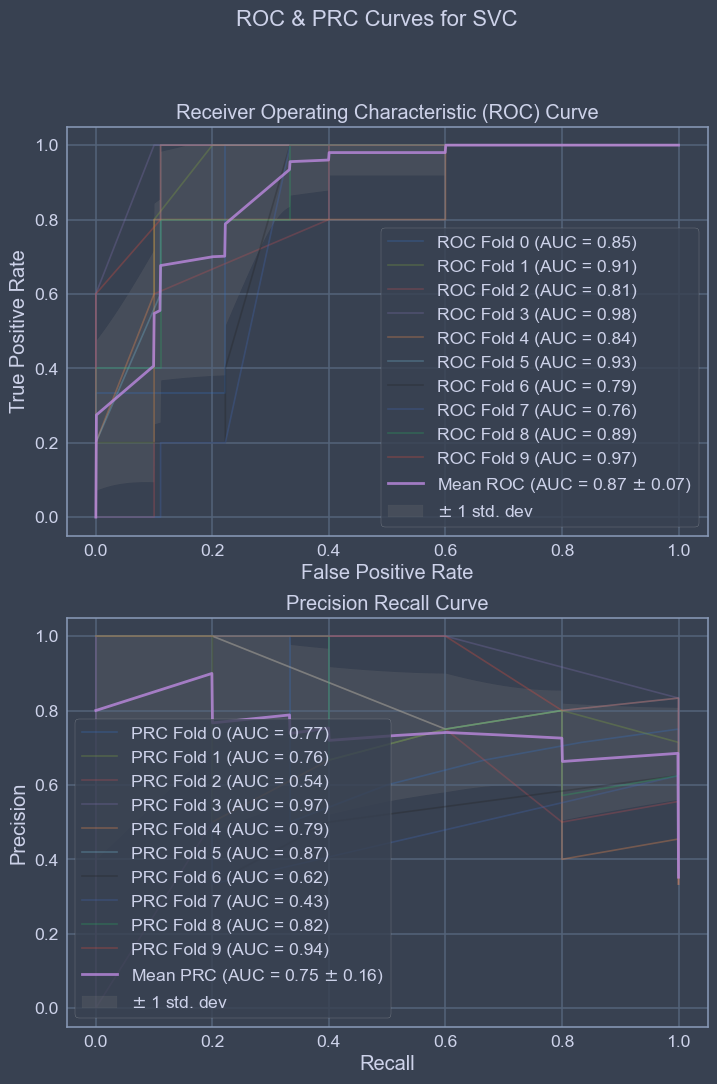

In [72]:
k_fold_roc_curve(svc_10f_outputs, "SVC")

--- Fold 0 ---
0.8
--- Fold 1 ---
0.7333333333333333
--- Fold 2 ---
0.7333333333333333
--- Fold 3 ---
0.8
--- Fold 4 ---
0.8666666666666667
--- Fold 5 ---
0.7857142857142857
--- Fold 6 ---
0.7857142857142857
--- Fold 7 ---
0.7142857142857143
--- Fold 8 ---
0.7857142857142857
--- Fold 9 ---
0.8571428571428571


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 526.32it/s]


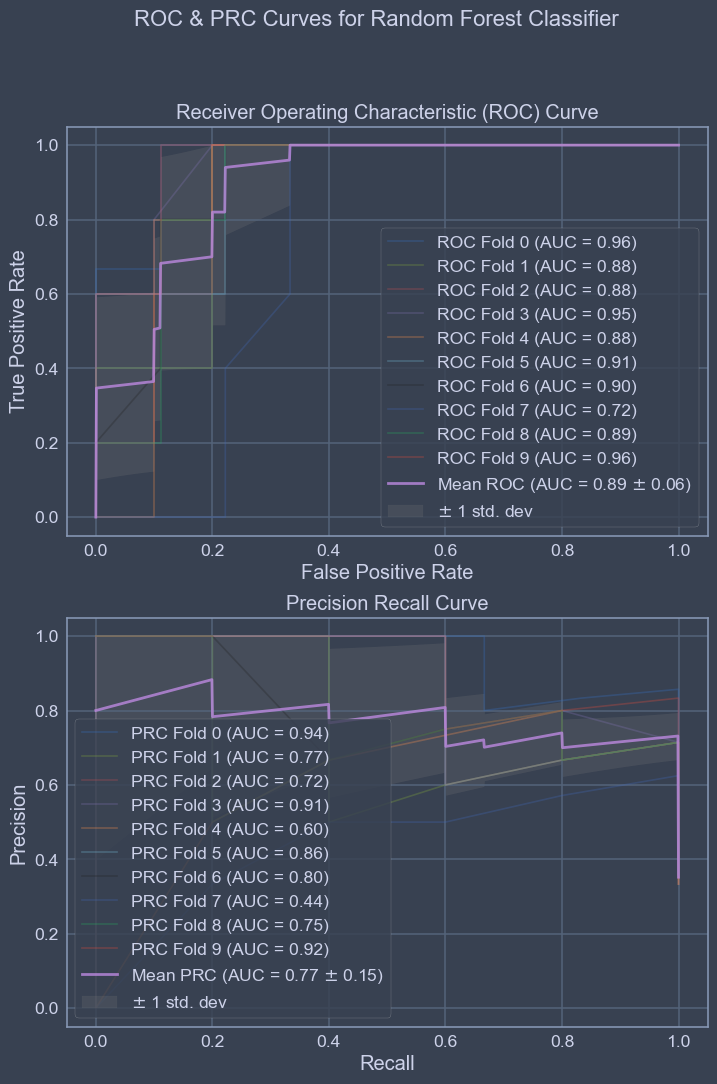

In [73]:
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc_10f_outputs = ten_fold_cross_validation(skf, rfc, X, Y)
k_fold_roc_curve(rfc_10f_outputs, "Random Forest Classifier")